# Figure 6 - model fit

This notebook displays the results of the regression model for percent biophony and the sound exposure level (SEL).

#### import statements

In [15]:
import pandas
from matplotlib import pyplot
from matplotlib.lines import Line2D
%matplotlib inline

In [16]:
import seaborn
from figutils import style

In [17]:
import numpy

#### load data

In [18]:
compare_PB = pandas.read_csv(r"C:\Users\JDDein\OneDrive\Documents\alpine soundscapes\appendicies\source\compare PB WAIC.csv")

In [19]:
compare_SEL = pandas.read_csv(r"C:\Users\JDDein\OneDrive\Documents\alpine soundscapes\appendicies\source\compare SEL WAIC.csv")

set styles

In [20]:
style.set_font()

In [21]:
seaborn.set()

## Plot

In [22]:
variables = compare_PB['variable'].unique()

In [23]:
variables = {
    'Buildings':'#ff0000',
    #'Other':'#ffeba3',
    'Other':'slategray',
    'Trees':'#009642',
    #'Herbaceous':'#bafca1',
    'Herbaceous':'yellowgreen',
    'd2n':'#000000'
}

In [24]:
names = {
    'Buildings':'buildings',
    'Other':'other const. areas',
    'Trees':'trees',
    'Herbaceous':'herb. vegetation',
    'd2n':str('D' + r'$_2$' + 'N')
}

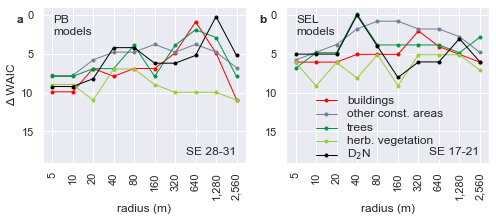

In [27]:
fig, ax = pyplot.subplots(1, 2, sharex=True, sharey=False)
fig.set_figwidth(6.81)
fig.set_figheight(3)
pyplot.subplots_adjust(left=0.08, bottom=0.27, right=0.99, top = 0.99, hspace=0, wspace=0.2)

for variable in variables:
    df = compare_PB[compare_PB['variable'] == variable]
    ax[0].plot(range(1,11), df['dWAIC'] + (numpy.random.rand()*0.5 - 0.25), color=variables[variable], marker='.', linewidth=1)
    #jitter = numpy.random.rand()*0.3
    #for i in range(10):
        #point = df['dWAIC'].iloc[i]
        #se = df['SE'].iloc[i]
        #ax[0].add_line(Line2D([i+1+jitter, i+1+jitter], [point - (se/2), point + (se/2)], color=variables[variable], linewidth=1))

for variable in variables:
    df = compare_SEL[compare_SEL['variable'] == variable]
    ax[1].plot(range(1,11), df['dWAIC'] + (numpy.random.rand()*0.5 - 0.25), color=variables[variable], marker='.', linewidth=1)

yl0 = ax[0].set_ylim(19, -1)
yl1 = ax[1].set_ylim(19, -1)

xt0 = ax[0].set_xticks([n for n in range(1,11)])
xl0 = ax[0].set_xticklabels(['5', '10', '20', '40', '80', '160', '320', '640', '1,280', '2,560'], rotation=90)
xl1 = ax[1].set_xticklabels(['5', '10', '20', '40', '80', '160', '320', '640', '1,280', '2,560'], rotation=90)

yt0 = ax[0].set_ylabel(u'Δ ' + 'WAIC')
#yt1 = ax[1].set_ylabel('dLOO')
xt0 = ax[0].set_xlabel('radius (m)')
xt1 = ax[1].set_xlabel('radius (m)')

#legend
ln = 0
for variable in variables:
    y = 11 + (1.75*ln)
    ax[1].add_line(Line2D([2,3],[y,y], color=variables[variable], linewidth=1))
    ax[1].plot(2.5, y, color=variables[variable], marker='.')
    ax[1].text(3.5, y, names[variable], horizontalalignment='left', verticalalignment='center')
    ln = ln + 1

#figure labels
title_font = {
    'size': 12.0,
    'weight': 'bold'
}

t1 = ax[0].text(-0.75, 0, 'a', horizontalalignment='left', verticalalignment='top', 
          fontdict=title_font)
t2 = ax[1].text(-0.75, 0, 'b', horizontalalignment='left', verticalalignment='top', 
          fontdict=title_font)

t3 = ax[0].text(0.05, 0.95, 'PB\nmodels', horizontalalignment='left', verticalalignment='top', transform=ax[0].transAxes)
t4 = ax[1].text(0.05, 0.95, 'SEL\nmodels', horizontalalignment='left', verticalalignment='top', transform=ax[1].transAxes)

t5 = ax[0].text(0.95, 0.1, 'SE 28-31', horizontalalignment='right', verticalalignment='top', transform=ax[0].transAxes)
t6 = ax[1].text(0.95, 0.1, 'SE 17-21', horizontalalignment='right', verticalalignment='top', transform=ax[1].transAxes)

save figure

In [28]:
fig.savefig(r"C:\Users\JDDein\Desktop\figure6.png", dpi = 1200)